# Logistic Regression on  Amazon Fine food Review 
The Amazon fine food dataset consists of reviews of fine foods from amazon
All data in one sqlite database. 568,454 food reviews Amazon users left up to October 2012
Data includes:

* Number of reviews :  568,454 reviews
* Number of user : 256,059 users
* Total Number of Producst : 74,258 products
* Time Span of taking Reviews : from Oct 1999 - Oct 2012
* Number of Columns/fields : 10

***Attributes Information :***
1. Id : Row Id
1. ProductId :Unique identifier for the product (74258 unique values)
1. UserId :Unqiue identifier for the user (256059 unique values)
1. ProfileName : Profile name of the user (218418 unique values )
1. HelpfulnessNumerator : Number of users who found the review helpful 
1. HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not 
1. Score : Rating between 1 and 5
1. Time : Timestamp for the review
1. Summary : Brief summary of the review (295744 unique values)
1. Text : Text of the review (393579 unique values)

> **Objective :** *Given a review ,determine whether a review is postive or negative*

**Q].** *How to determine if a review is postive or negative?*

**Ans.** We can use the Score/rating. A rating of 4 or 5 could be considered as positive review & A rating of 1 or 2 can be consider as negative review . A rating of 3 can be consider as neutral and can be ignored . This is the approximation and proxy way to approach way of determing the polarity(positivity/negativity) of reviews.

# Importing important library

In [39]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#mterics 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score

import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

import os
import pickle 
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import os
from bs4 import BeautifulSoup
import swifter
from nltk.corpus import stopwords
import nltk
!pip3 install kaggle



You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [40]:
import os
import requests
from IPython.display import display
import zipfile

import os
import requests
from IPython.display import display
import zipfile

def download_dataset(url, file_name, folder='data'):
    """
    Download a public dataset from Kaggle using a direct URL in a Jupyter notebook.

    :param url: Direct download URL of the dataset
    :param file_name: Custom name for the downloaded zip file
    :param folder: Relative folder where the dataset will be saved (default: 'data')
    """
    # Ensure the directory exists
    path = folder
    if not os.path.exists(path):
        os.makedirs(path)

    # Full path for the zip file
    file_path = os.path.join(path, file_name)

    # Download the file from the given URL
    print(f"Downloading dataset as {file_name}...")
    
    response = requests.get(url, stream=True)
    
    with open(file_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    
    print(f"Download complete. File saved as {file_path}")
    
    return file_path

def extract_zip(file_path, extract_to='.'):
    """
    Extract a zip file in the specified relative directory.

    :param file_path: Path of the zip file to be extracted
    :param extract_to: Path where the files will be extracted (default: current directory)
    """
    print(f"Extracting {file_path} to {extract_to}...")
    
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    print(f"Files extracted to {extract_to}.")

relative_path = "./dataset"
file_name = "amazon_fine_food_reviews.csv"

download_dataset("https://storage.googleapis.com/kaggle-data-sets/18/2157/bundle/archive.zip", file_name=file_name,  folder=relative_path )

#download_dataset("https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/download?datasetVersionNumber=2", file_name=file_name,  folder=relative_path )
#extract_zip(relative_path,  relative_path)

Download complete. File saved as ./dataset/amazon_fine_food_reviews.csv


'./dataset/amazon_fine_food_reviews.csv'

# Reading Data from Sqlite database and changing the review score to be positive and negative.

In [41]:
#Using the sqlite table to read data
con = sqlite3.connect('/Users/krithishetty/Downloads/finefoodreviews/database.sqlite')
# Filtering only Positive and Negative Reviews i.e not taking into consideration those reviews with score=3
filtered_data= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""",con)
#Given reviews with score>3 a postive rating "1" and reviews with score <3 a negative "0"
#constucting a function
def partition(x):
    if x<3:
        return 0
    return 1
#Changing reviews with score<3 to be negative "0" and score > 3 to be positive "1"
actualscore=filtered_data['Score']
Positve_Negative=actualscore.map(partition)
filtered_data['Score']=Positve_Negative
print("No. of data points in Dataset:",filtered_data.shape)
filtered_data.head(3)


No. of data points in Dataset: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [42]:
display= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3 AND UserId ='AR5J8UI46CURR' ORDER BY ProductId """,con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


**As it can be seen above the same user has multiple reviews of the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)**

**ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on**

**It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.**

**The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product**

In [43]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
display.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [44]:
#Deduplication entries
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [45]:
#Checking to see how much % of data still remains
print('The total data remain after cleaning data ',(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

The total data remain after cleaning data  69.25890143662969


In [46]:
final_data[final_data['HelpfulnessNumerator']>final_data['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [47]:
display=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductID""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


**Observation:** It was seen that in 2 rows given above the value of HelpfullnessNumerator is Greater than HelpfullnessDenominator which is not practically hence such rows are too removed from dataset

In [48]:
final_data=final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]
final_data.shape

(364171, 10)

(364171, 10)


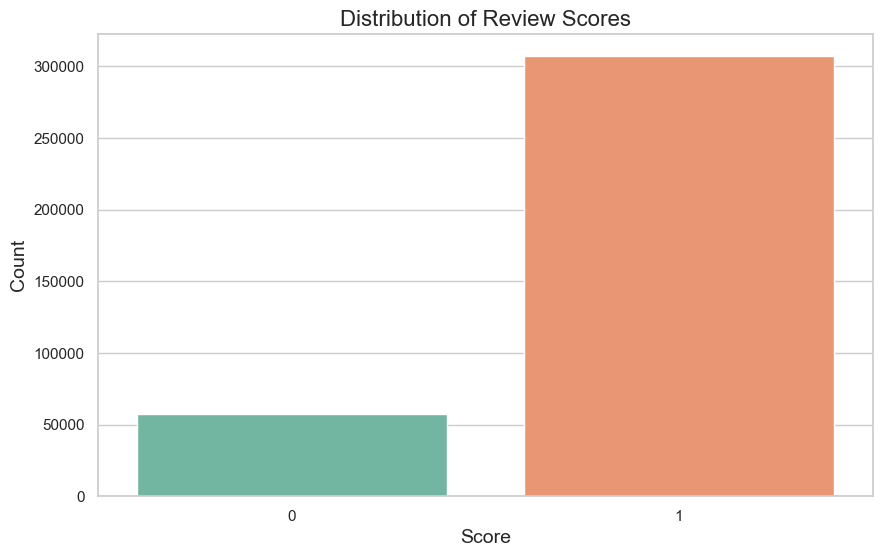

Text(0, 0.5, 'Score')

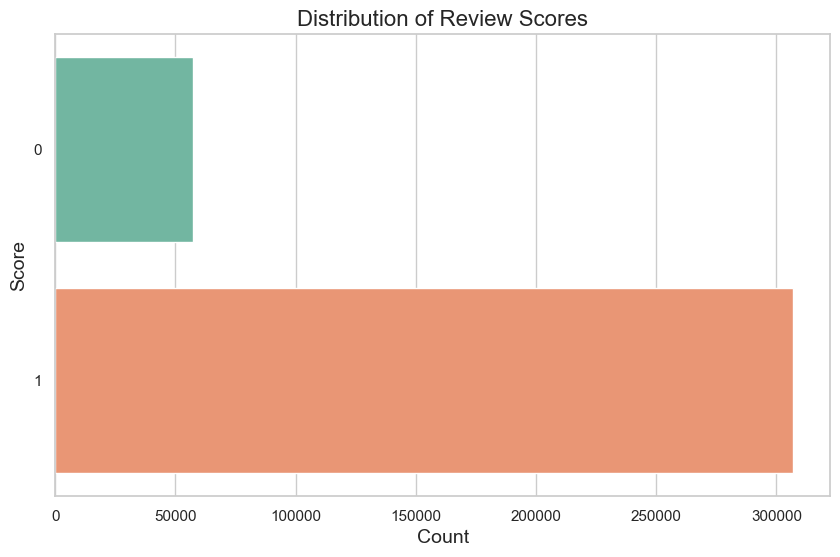

In [49]:
# before starting the next phase of text preprocessing lets see the no. of entries left
print(final_data.shape)
#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()
sns.set(style="whitegrid")
custom_palette = sns.color_palette("Set2")

# Create a count plot for the 'Score' column with the custom palette
plt.figure(figsize=(10, 6))
sns.countplot(x='Score', data=final_data, palette=custom_palette)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Create a count plot with 'Score' on the y-axis using the custom palette
plt.figure(figsize=(10, 6))
sns.countplot(y='Score', data=final_data, palette=custom_palette)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Text Preprocessing
**Now we have finished deduplication. Now our data requires some preprocessing before we go on futher anlysis and make the prediction model Hence in the preprocessing phase we do the following steps given below**

1. Begin by removing html tags
1. Removing any punctution or limited set of special character:like ,or . or # etc
1. Check the words is made up of english letters and is not alpha-numeric
1. Check to see if the length of the words is greater than 2 (as it was research that there is no adjective in 2 letter)
1. Convert the words to lowercase
1. Remove stopwords
1. Snowball stemming the word(it is observed that Snoball stemming is better that Porter stemming)

***After this we will collect the words and will use to describe positive and negative reviews.***

In [50]:
# Finding the first review with HTML tags
for i, review in enumerate(final_data['Text'].values):
    # Use regex to find HTML tags in the review text
    if re.search(r'<.*?>', review):
        print("First review containing HTML tags:")
        print(review)
        print(f"Found at index: {i}")
        break
else:
    print("No HTML tags found in any review.")


First review containing HTML tags:
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Found at index: 6


In [51]:


# Initialize stopwords and customize the list
stop_words = set(stopwords.words('english'))  # Create a set of stopwords from NLTK
print("Original stopwords:", stop_words)  # Display all stopwords in NLTK

# List of stopwords to exclude
excluding_stop = [
    'against', 'not', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
    'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 
    'needn', "needn't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
    'won', "won't", 'wouldn', "wouldn't"
]

# Remove excluded stopwords from the stop_words set
stop_words = [word for word in stop_words if word not in excluding_stop]

print("****" * 15)
print("Customized stopwords:", stop_words)

# Initialize the Snowball Stemmer
snowball_stemmer = SnowballStemmer('english')
print("\n", "****" * 15)
print("Stemmed word for 'tasty':", snowball_stemmer.stem('tasty'))  # Stemming example

# Function to clean HTML tags from a sentence
def clean_html(text):
    """
    Remove HTML tags from the given text.
    
    :param text: The input string that may contain HTML tags.
    :return: A string with HTML tags removed.
    """
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', text)
    return cleantext

# Function to clean punctuation or special characters from a sentence
def clean_punctuation(text):
    """
    Remove punctuation and special characters from the given text.
    
    :param text: The input string that may contain punctuation or special characters.
    :return: A cleaned string without specified characters.
    """
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', text)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r'', cleaned)
    return cleaned


Original stopwords: {'o', 'being', 'above', 'd', "weren't", 'couldn', 'how', 'our', 'a', 'down', 's', 'during', 'all', "don't", 'from', 'now', 'against', "mightn't", 'which', 'its', 'll', "you'd", 'whom', 'about', 'there', 'he', 'himself', "she's", 'further', 'needn', 'ours', 'doing', 'on', 'why', 'and', 'here', 'out', "should've", 'own', "you've", 'because', 'between', 'most', 'i', 'hasn', 'below', 'yours', 'once', 'such', "hadn't", 'but', 'has', 'were', 'yourselves', "that'll", 'me', 'both', 'for', "aren't", "didn't", 'him', 'are', "haven't", 'too', 'we', 'after', 'just', 'themselves', 'myself', 'over', 'of', 'doesn', 'her', 'by', 'hadn', 'each', 'theirs', 'other', 'she', 'under', 'you', 'ma', "isn't", 'they', 'have', 'while', 'where', 'shouldn', 'does', 'not', 'the', "wasn't", "hasn't", "shouldn't", 'as', 'through', "you'll", 't', 'don', 'so', 'no', 'their', "shan't", 've', "wouldn't", 'ourselves', 'it', 'up', 'been', 'if', 'did', 'didn', 'until', 'into', 'y', 'your', 'these', 'am',

In [52]:
# printing some random reviews
sent_0 = final_data['Text'].values[6]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than s

In [53]:
sent_0=re.sub(r'https\S+','',sent_0)
sent_1000=re.sub(r'https\S+','',sent_1000)
sent_1500=re.sub(r'https\S+','',sent_1500)
sent_4900=re.sub(r'http\S+', '', sent_4900)

print(sent_0)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [54]:
pip install beautifulsoup4

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install lxml

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [56]:
def decontracted(phrase):
    phrase=re.sub(r"won't",'will not',phrase)
    phrase=re.sub(r"can\'t",'can not',phrase)
    phrase=re.sub(r"n\'t",'not',phrase)
    phrase=re.sub(r"\'re",'are',phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [57]:
sent_0=re.sub("\S\d\S","",sent_0).strip()
print(sent_0)
print("="*50)

sent_1500=re.sub('[^A-Za-z0-9]+',' ',sent_1500)
print(sent_1500)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today s Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Unt

In [58]:

# Download the stopwords if you haven't already
nltk.download('stopwords')

# Define the stopwords list
stop = set(stopwords.words('english'))

# Assuming the decontracted function is already defined

def preprocess_sentence(sentence):
    """
    Preprocesses a given sentence by performing the following steps:
    1. Remove URLs.
    2. Remove HTML tags.
    3. Expand contractions.
    4. Remove words containing digits.
    5. Remove special characters.
    6. Convert to lowercase and remove stopwords.
    """

    # Remove URLs
    sentence = re.sub(r"http\S+", "", sentence)
    
    # Remove HTML tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    
    # Expand contractions
    sentence = decontracted(sentence)
    
    # Remove words containing digits
    sentence = re.sub(r"\S*\d\S*", "", sentence).strip()
    
    # Remove special characters, keeping only letters
    sentence = re.sub(r'[^A-Za-z]+', ' ', sentence)
    
    # Convert to lowercase, remove stopwords, and return the cleaned sentence
    sentence = ' '.join(word.lower() for word in sentence.split() if word.lower() not in stop)
    
    return sentence.strip()

# Apply the preprocessing function to the 'Text' column using swifter for faster processing
final_data['Cleaned_Text'] = final_data['Text'].swifter.apply(preprocess_sentence)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


Pandas Apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [04:42<00:00, 1288.69it/s]


In [59]:

# Apply the preprocessing function to the 'Summary' column using swifter for faster processing
final_data['Cleaned_Summary'] = final_data['Summary'].swifter.apply(preprocess_sentence)


Pandas Apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [02:22<00:00, 2554.17it/s]


In [60]:
pip install bs4

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [61]:
# #SENTENCES Containing HTML tags
# i=0;
# for sentence in final_data['Text'].values:
#     if (len(re.findall('<.*?>',sentence))):
#         break;
#     print("="*50)
#     print(i,")>>",sentence)
#     i=i+1
# print("="*50)

# Enhanced code to identify sentences containing HTML tags

# for i, sentence in enumerate(final_data['Text'].values):
#     # Check if the sentence contains any HTML tags
#     if re.search('<.*?>', sentence):
#         print(f"\n{'='*50}")
#         print(f"First sentence containing HTML tags found at index {i}:")
#         print(f"{i}) >> {sentence}")
#         print(f"{'='*50}\n")
#         break
#     else:
#         print(f"{i}) >> {sentence}")
#         print(f"{'-'*50}")

# # Final message if no HTML tags are found
# if not re.search('<.*?>', sentence):
#     print("No sentences containing HTML tags were found in the dataset.")


# Iterate over sentences and check for HTML tags using BeautifulSoup
for i, sentence in enumerate(final_data['Text'].values):
    # Parse the sentence with BeautifulSoup
    soup = BeautifulSoup(sentence, "html.parser")
    
    # Check if BeautifulSoup parsed any tags
    if soup.find():
        print(f"\n{'='*50}")
        print(f"First sentence containing HTML tags found at index {i}:")
        print(f"{i}) >> {sentence}")
        print(f"{'='*50}\n")
        break
    else:
        print(f"{i}) >> {sentence}")
        print(f"{'-'*50}")

# Final message if no HTML tags are found
if not soup.find():
    print("No sentences containing HTML tags were found in the dataset.")


0) >> this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
--------------------------------------------------
1) >> I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------
2) >> This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
--------------------------------------------------
3) >> Thi

In [62]:
# converting time in unit=sec
final_data['Time']=pd.to_datetime(final_data['Time'],unit='s')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,2007-11-11,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,2007-10-04,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,2004-02-06,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,2002-04-10,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


# Sorting dataset based on 'Time' feature

In [63]:
final_data=final_data.sort_values('Time',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,modern day fairy tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,fantastic


In [64]:
#Store the final table into an SQLITE table for future
connection=sqlite3.connect('final12.sqlite')
c=connection.cursor
connection.text_factory=str
final_data.to_sql('Reviews',connection,schema=None,if_exists='replace',index=True,index_label=True,chunksize=None,dtype=None)
connection.close()

Equalizing Class Distribution is Important:
Avoiding Model Bias:

If the model is trained on an imbalanced dataset, it might learn to always predict the majority class because doing so minimizes the overall error. This leads to a model that performs well on the majority class but poorly on the minority class.
By sampling an equal number of positive and negative examples, the model is forced to learn patterns in both classes, leading to a more balanced and fair model.
Improved Evaluation Metrics:

Evaluation metrics like accuracy can be misleading in the presence of class imbalance. For example, if 90% of the data is positive, a model that always predicts "positive" will have 90% accuracy, but it would be completely useless for identifying negative samples.
Equalizing the number of samples helps in getting more meaningful evaluation metrics, such as precision, recall, and F1-score, which provide a better understanding of the model's performance across both classes.
Better Generalization:

A model trained on a balanced dataset is more likely to generalize well to new, unseen data. If the test or real-world data has a different distribution (e.g., more negatives), a model trained on balanced data is better equipped to handle this.
Preventing Overfitting:

In some cases, an imbalanced dataset can cause the model to overfit to the majority class because it sees much more data from that class during training. By balancing the classes, the model has to learn from a more diverse set of examples, reducing the risk of overfitting.


In [65]:
# taking equal no. of negative and positive data points
data_pos=final_data[final_data['Score']==1].sample(n=57000)
data_neg=final_data[final_data['Score']==0].sample(n=57000)
final=pd.concat([data_pos,data_neg])
final.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
85543,93153,B004YV80OE,A3C9YGB4H90PDE,Karla Cook,0,0,0,2011-10-11,not impressed,My family was not impressed with this dish. I ...,family impressed dish wasnot expecting taste l...,impressed
475822,514557,B000CQ6KTM,A155VP0YLXER8A,Eric Hirsch,1,5,0,2012-03-01,If you like eating GLUE,"I buy quality, more natural mac & cheese quite...",buy quality natural mac cheese quite regularly...,like eating glue
426844,461620,B000F9XBBQ,A3KPRKS4YSOZWN,All Rater,1,1,0,2012-03-30,Terrible,It has hidden MSG (a known neurotoxin). Terrib...,hidden msg known neurotoxin terrible tasting l...,terrible
437280,472899,B004HLAHUQ,AMTI5N71G3A9,GaGatorGal,0,0,0,2012-03-06,Bitter and Watery,While I know dark chocolate is not super sweet...,know dark chocolate super sweet like milk choc...,bitter watery
195745,212194,B000CNB4LE,A11R1IA3Y91WS6,Little LuLu,1,1,0,2012-09-03,Container top problems,"I love the product itself, but I do not like t...",love product like container garage large refri...,container top problems


Performs hyperparameter tuning for a logistic regression model using cross-validation to determine the optimal regularization strength (C value) for the model.
Evaluate different regularization strengths (C values) for a logistic regression model using cross-validation to find the value that minimizes misclassification error, and then visualizes the relationship between C values and misclassification error.

Shape of X (114000,)
Shape of y (114000,)
Shape of X_train: (55860,) Shape of y_train: (55860,)
Shape of X_cv: (23940,) Shape of y_cv: (23940,)
Shape of X_test: (34200,) Shape of y_test: (34200,)
Evaluating Logistic Regression with Bag of Words:


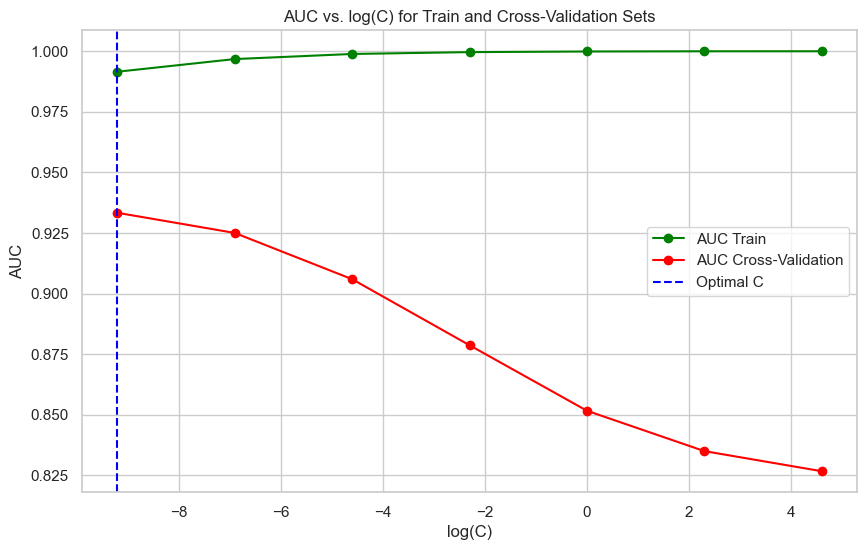

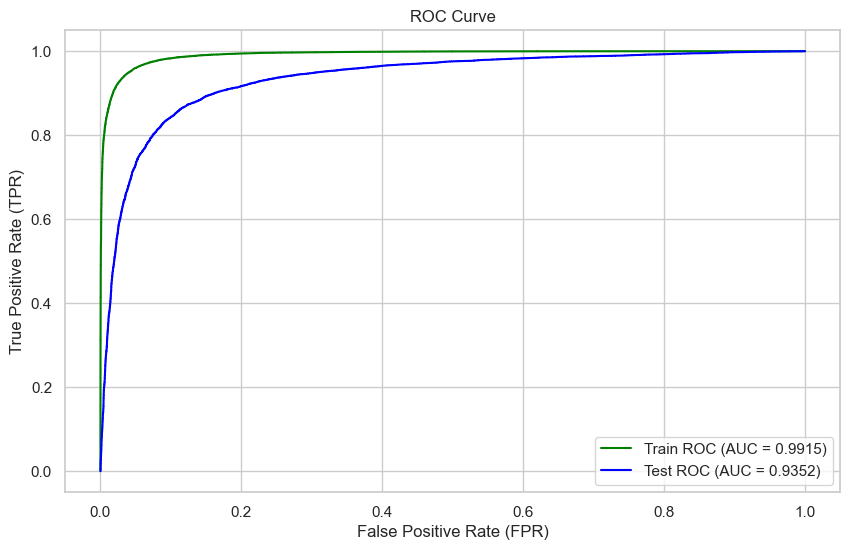

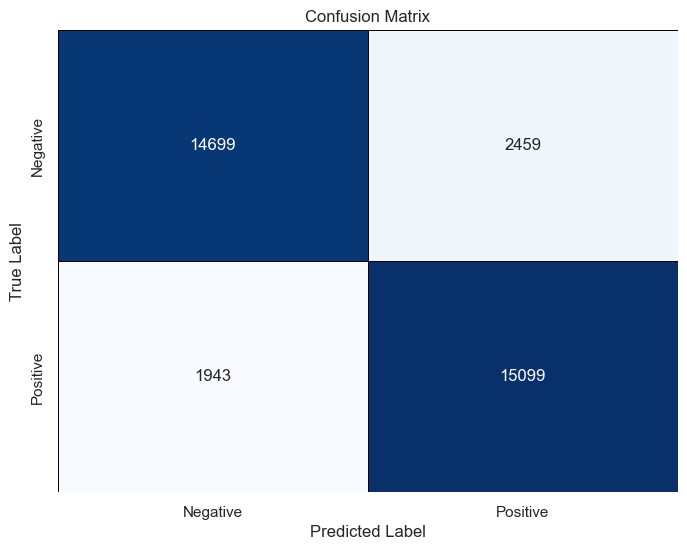

Misclassification Error: 0.1287
Evaluating RandomForest with Bag of Words:
Evaluating Logistic Regression with TF-IDF:


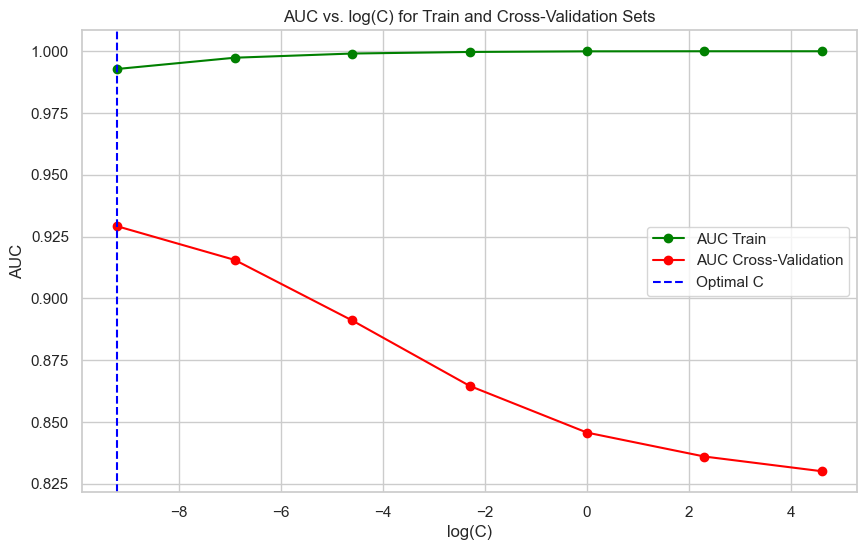

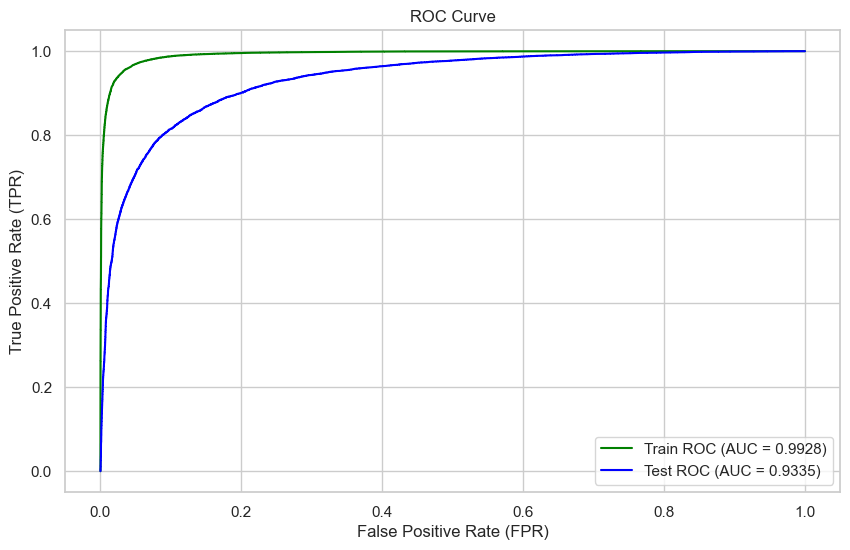

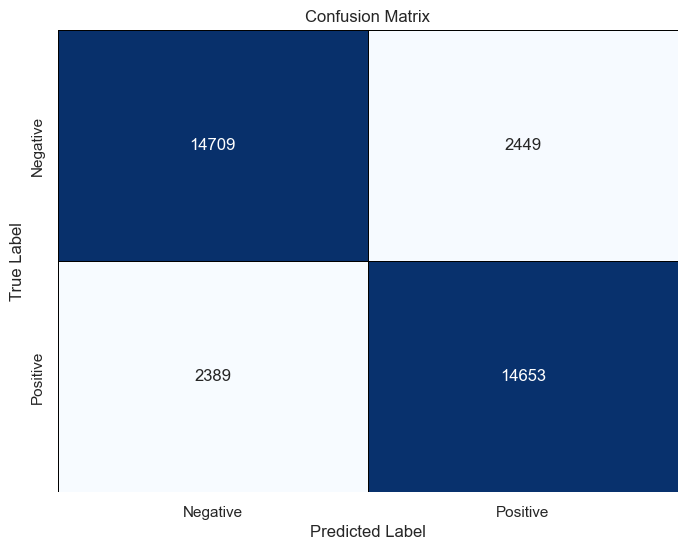

Misclassification Error: 0.1415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34200/34200 [01:48<00:00, 314.21it/s]


Evaluating Logistic Regression with Average Word2Vec:


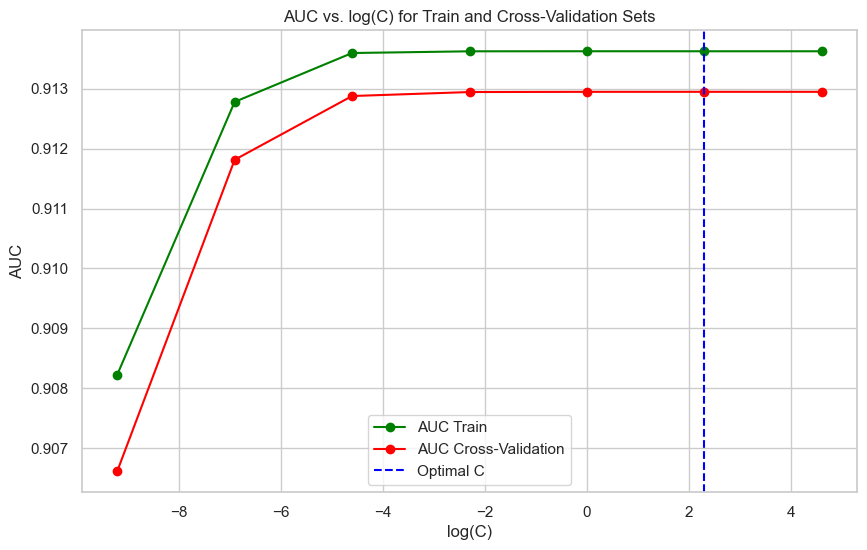

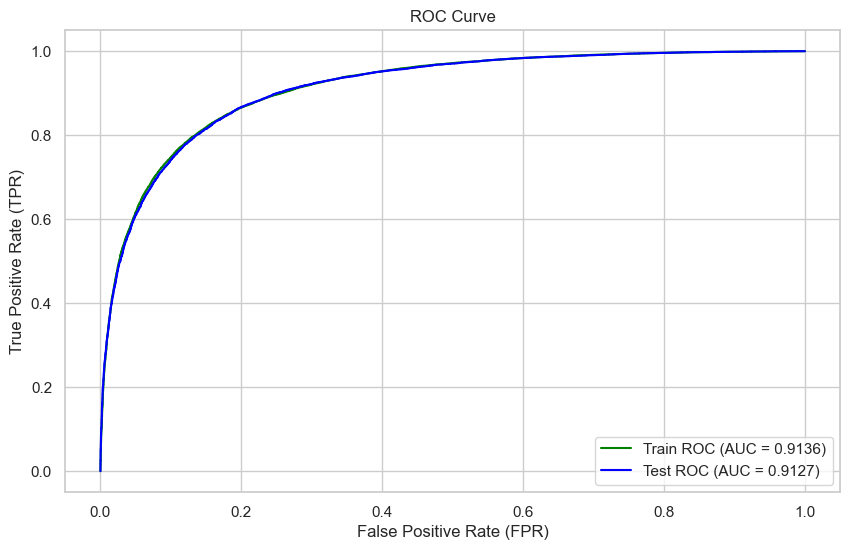

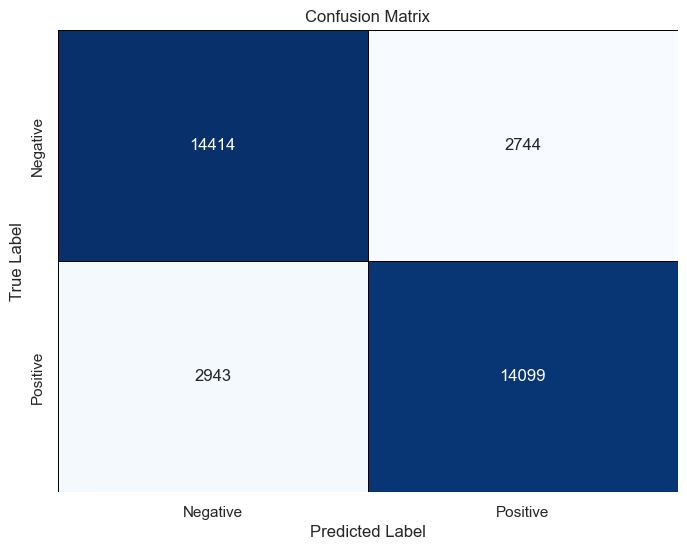

Misclassification Error: 0.1663


NameError: name 'param_grid_rf' is not defined

In [77]:

#Do not delete
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from joblib import Parallel, delayed
import math
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from prettytable import PrettyTable



regularization_strengths=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Taking equal number of positive and negative data points
data_pos = final_data[final_data['Score'] == 1].sample(n=57000, random_state=0)
data_neg = final_data[final_data['Score'] == 0].sample(n=57000, random_state=0)
final = pd.concat([data_pos, data_neg])

# Checking shapes to ensure consistency
y = final['Score']
X = final['Cleaned_Text']
print("Shape of X", X.shape)
print("Shape of y", y.shape)

# Splitting the dataset
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_tr, y_tr, test_size=0.30, random_state=0)

# Verify that the shapes match
print('Shape of X_train:', X_train.shape, 'Shape of y_train:', y_train.shape)
print('Shape of X_cv:', X_cv.shape, 'Shape of y_cv:', y_cv.shape)
print('Shape of X_test:', X_test.shape, 'Shape of y_test:', y_test.shape)

# Function to plot AUC vs. Log(C) for Train and Cross-Validation Sets
def plot_auc_vs_logc(auc_train, auc_cv, regularization_strengths):
    log_reg_strengths = [math.log(x) for x in regularization_strengths]
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_strengths, auc_train, color='green', marker='o', label='AUC Train')
    plt.plot(log_reg_strengths, auc_cv, color='red', marker='o', label='AUC Cross-Validation')
    plt.axvline(x=log_reg_strengths[np.argmax(auc_cv)], color='blue', linestyle='--', label='Optimal C')
    plt.legend(loc='best')
    plt.xlabel('log(C)')
    plt.ylabel('AUC')
    plt.title('AUC vs. log(C) for Train and Cross-Validation Sets')
    plt.grid(True)
    plt.show()

# Function to train and evaluate Logistic Regression model with cross-validation
def train_evaluate_logreg(X_train, y_train, X_cv, y_cv, X_test, y_test, regularization_strengths, max_iter=10000):
    auc_train_scores = []
    auc_cv_scores = []

    for C in regularization_strengths:
        model = LogisticRegression(penalty='l2', C=C, max_iter=10000)
        model.fit(X_train, y_train)

        y_train_pred_prob = model.predict_proba(X_train)[:, 1]
        y_cv_pred_prob = model.predict_proba(X_cv)[:, 1]

        auc_train_scores.append(roc_auc_score(y_train, y_train_pred_prob))
        auc_cv_scores.append(roc_auc_score(y_cv, y_cv_pred_prob))

    optimal_C = regularization_strengths[np.argmax(auc_cv_scores)]
    plot_auc_vs_logc(auc_train_scores, auc_cv_scores, regularization_strengths)

    # Train final model with optimal C
    model = LogisticRegression(penalty='l2', C=optimal_C, max_iter=max_iter)
    model.fit(X_train, y_train)

    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curves and AUC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

    auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_test = roc_auc_score(y_test, y_test_pred_prob)

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.4f})', color='green')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.4f})', color='blue')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    y_test_pred = model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_test_pred)
    class_labels = ["Negative", "Positive"]
    df_confusion_mat = pd.DataFrame(confusion_mat, columns=class_labels, index=class_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Misclassification Error
    misclassification_error = 1 - accuracy_score(y_test, y_test_pred)
    print(f"Misclassification Error: {misclassification_error:.4f}")

    return auc_test, model

# Function to train and evaluate RandomForest model with cross-validation
def train_evaluate_rf(X_train, y_train, X_cv, y_cv, X_test, y_test, param_grid):
    rf = RandomForestClassifier(random_state=0)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    
    y_train_pred_prob = best_rf.predict_proba(X_train)[:, 1]
    y_test_pred_prob = best_rf.predict_proba(X_test)[:, 1]

    # Compute ROC curves and AUC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

    auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_test = roc_auc_score(y_test, y_test_pred_prob)

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.4f})', color='green')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.4f})', color='blue')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    y_test_pred = best_rf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_test_pred)
    class_labels = ["Negative", "Positive"]
    df_confusion_mat = pd.DataFrame(confusion_mat, columns=class_labels, index=class_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Misclassification Error
    misclassification_error = 1 - accuracy_score(y_test, y_test_pred)
    print(f"Misclassification Error: {misclassification_error:.4f}")

    return auc_test, best_rf


# Bag of Words (BoW)
bow_count_vect = CountVectorizer()
bow_count_vect.fit(X_train)

X_train_bow = bow_count_vect.transform(X_train)
X_cv_bow = bow_count_vect.transform(X_cv)
X_test_bow = bow_count_vect.transform(X_test)

# Standardize the data
scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_cv_bow = scaler.transform(X_cv_bow)
X_test_bow = scaler.transform(X_test_bow)

# Train and evaluate Logistic Regression using Bag of Words
print("Evaluating Logistic Regression with Bag of Words:")
auc_bow, model_bow = train_evaluate_logreg(X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test, regularization_strengths)

# Train and evaluate RandomForest using Bag of Words
print("Evaluating RandomForest with Bag of Words:")
# param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
# auc_rf_bow, model_rf_bow = train_evaluate_rf(X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test, param_grid_rf)

# TF-IDF
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)

X_train_tfidf = tfidf_vect.transform(X_train)
X_cv_tfidf = tfidf_vect.transform(X_cv)
X_test_tfidf = tfidf_vect.transform(X_test)

# Standardize the data
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_cv_tfidf = scaler.transform(X_cv_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

# Train and evaluate Logistic Regression using TF-IDF
print("Evaluating Logistic Regression with TF-IDF:")
auc_tfidf, model_tfidf = train_evaluate_logreg(X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test, regularization_strengths)

# Train and evaluate RandomForest using TF-IDF
# print("Evaluating RandomForest with TF-IDF:")
# auc_rf_tfidf, model_rf_tfidf = train_evaluate_rf(X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test, param_grid_rf)

# Word2Vec
list_of_X_train = [sentence.split() for sentence in X_train]
list_of_X_cv = [sentence.split() for sentence in X_cv]
list_of_X_test = [sentence.split() for sentence in X_test]

w2v_model = Word2Vec(list_of_X_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

# Function to compute average Word2Vec for each sentence
def compute_avg_w2v(sentences, model, w2v_words):
    sentence_vectors = []
    for sentence in tqdm(sentences):
        sent_vec = np.zeros(50)
        count_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = model.wv[word]
                sent_vec += vec
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sentence_vectors.append(sent_vec)
    return sentence_vectors

X_train_avg_w2v = compute_avg_w2v(list_of_X_train, w2v_model, w2v_words)
X_cv_avg_w2v = compute_avg_w2v(list_of_X_cv, w2v_model, w2v_words)
X_test_avg_w2v = compute_avg_w2v(list_of_X_test, w2v_model, w2v_words)

# Standardize the data
X_train_avg_w2v = scaler.fit_transform(X_train_avg_w2v)
X_cv_avg_w2v = scaler.transform(X_cv_avg_w2v)
X_test_avg_w2v = scaler.transform(X_test_avg_w2v)

# Train and evaluate Logistic Regression using Average Word2Vec
print("Evaluating Logistic Regression with Average Word2Vec:")
auc_avg_w2v, model_avg_w2v = train_evaluate_logreg(X_train_avg_w2v, y_train, X_cv_avg_w2v, y_cv, X_test_avg_w2v, y_test, regularization_strengths)

# Train and evaluate RandomForest using Average Word2Vec
#print("Evaluating RandomForest with Average Word2Vec:")
#auc_rf_avg_w2v, model_rf_avg_w2v = train_evaluate_rf(X_train_avg_w2v, y_train, X_cv_avg_w2v, y_cv, X_test_avg_w2v, y_test, param_grid_rf)

# # TF-IDF Weighted Word2Vec
# def compute_weighted_w2v(X_train, X_cv, X_test, tfidf_vect, w2v_model):
#     tfidf_w2v_train = np.zeros((X_train.shape[0], 50))
#     tfidf_w2v_cv = np.zeros((X_cv.shape[0], 50))
#     tfidf_w2v_test = np.zeros((X_test.shape[0], 50))

#     tfidf_feature_names = tfidf_vect.get_feature_names_out()
#     tfidf_matrix_train = tfidf_vect.transform(X_train).toarray()
#     tfidf_matrix_cv = tfidf_vect.transform(X_cv).toarray()
#     tfidf_matrix_test = tfidf_vect.transform(X_test).toarray()

#     for i, sentence in enumerate(X_train):
#         for word in sentence.split():
#             if word in w2v_model.wv and word in tfidf_feature_names:
#                 tfidf_w2v_train[i] += tfidf_matrix_train[i, tfidf_feature_names.tolist().index(word)] * w2v_model.wv[word]

#     for i, sentence in enumerate(X_cv):
#         for word in sentence.split():
#             if word in w2v_model.wv and word in tfidf_feature_names:
#                 tfidf_w2v_cv[i] += tfidf_matrix_cv[i, tfidf_feature_names.tolist().index(word)] * w2v_model.wv[word]

#     for i, sentence in enumerate(X_test):
#         for word in sentence.split():
#             if word in w2v_model.wv and word in tfidf_feature_names:
#                 tfidf_w2v_test[i] += tfidf_matrix_test[i, tfidf_feature_names.tolist().index(word)] * w2v_model.wv[word]

#     return tfidf_w2v_train, tfidf_w2v_cv, tfidf_w2v_test

# X_train_w2v_weighted, X_cv_w2v_weighted, X_test_w2v_weighted = compute_weighted_w2v(X_train, X_cv, X_test, tfidf_vect, w2v_model)

# Standardize the data
# X_train_w2v_weighted = scaler.fit_transform(X_train_w2v_weighted)
# X_cv_w2v_weighted = scaler.transform(X_cv_w2v_weighted)
# X_test_w2v_weighted = scaler.transform(X_test_w2v_weighted)

# Train and evaluate Logistic Regression using TF-IDF Weighted Word2Vec
#print("Evaluating Logistic Regression with TF-IDF Weighted Word2Vec:")
#auc_w2v_weighted, model_w2v_weighted = train_evaluate_logreg(X_train_w2v_weighted, y_train, X_cv_w2v_weighted, y_cv, X_test_w2v_weighted, y_test, regularization_strengths=[0.1, 1, 10], max_iter=1000)

# # Train and evaluate RandomForest using TF-IDF Weighted Word2Vec
# print("Evaluating RandomForest with TF-IDF Weighted Word2Vec:")
# auc_rf_w2v_weighted, model_rf_w2v_weighted = train_evaluate_rf(X_train_w2v_weighted, y_train, X_cv_w2v_weighted, y_cv, X_test_w2v_weighted, y_test, param_grid_rf)

# Compare models using PrettyTable
comparison_table = PrettyTable()
comparison_table.field_names = ["Model", "Vectorizer", "Regularization", "Feature Engineering", "Hyperparameter (C or Grid)", "AUC"]

comparison_table.add_row(["Logistic Regression", "Bag of Words", "L2", "None", 0.0001, auc_bow])
# comparison_table.add_row(["RandomForest", "Bag of Words", "None", "GridSearchCV", str(param_grid_rf), auc_rf_bow])

comparison_table.add_row(["Logistic Regression", "TF-IDF", "L2", "None", 10000, auc_tfidf])
# comparison_table.add_row(["RandomForest", "TF-IDF", "None", "GridSearchCV", str(param_grid_rf), auc_rf_tfidf])

comparison_table.add_row(["Logistic Regression", "Average W2V", "L2", "None", 10, auc_avg_w2v])
# comparison_table.add_row(["RandomForest", "Average W2V", "None", "GridSearchCV", str(param_grid_rf), auc_rf_avg_w2v])

# comparison_table.add_row(["Logistic Regression", "TF-IDF Weighted W2V", "L2", "None", 1, auc_w2v_weighted])
# comparison_table.add_row(["RandomForest", "TF-IDF Weighted W2V", "None", "GridSearchCV", str(param_grid_rf), auc_rf_w2v_weighted])

print(comparison_table)



In [ ]:
# Function to analyze and classify a review
def analysis_review(review_text, model, vectorizer):
    review_vectorized = vectorizer.transform([review_text])
    sentiment_prob = model.predict_proba(review_vectorized)[0, 1]
    sentiment = 'Positive' if sentiment_prob >= 0.5 else 'Negative'
    return sentiment, sentiment_prob

# Example review analysis
example_review = "This product is fantastic! I love it."
sentiment, probability = analysis_review(example_review, model_tfidf, tfidf_vect)
print(f"Review: '{example_review}'")
print(f"Sentiment: {sentiment} (Probability: {probability:.4f})")


In [ ]:
example_review = "This product is bad! I dont love it."
sentiment, probability = analysis_review(example_review, model_tfidf, tfidf_vect)
print(f"Review: '{example_review}'")
print(f"Sentiment: {sentiment} (Probability: {probability:.4f})")


Review: 'This product is bad! I dont love it.'
Sentiment: Negative (Probability: 0.4937)


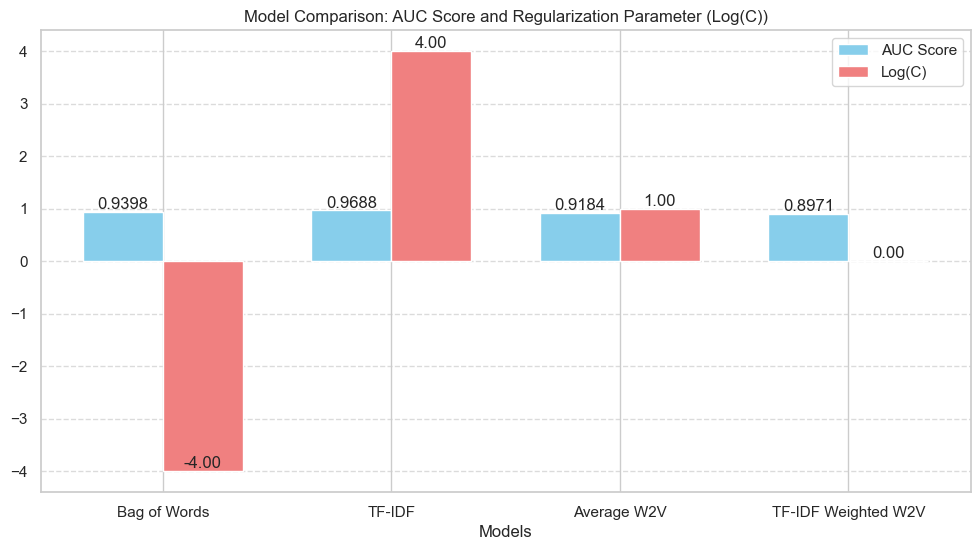

In [68]:
import numpy as np

# Data for the models
models = ['Bag of Words', 'TF-IDF', 'Average W2V', 'TF-IDF Weighted W2V']
auc_scores = [0.9398, 0.9688, 0.9184, 0.8971]
C_values = [0.0001, 10000, 10, 1]

# Normalize C values for comparison
C_normalized = np.log10(C_values)

# Bar width
bar_width = 0.35

# Set up positions for bars
index = np.arange(len(models))

# Create grouped bar chart
plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, auc_scores, bar_width, label='AUC Score', color='skyblue')
bar2 = plt.bar(index + bar_width, C_normalized, bar_width, label='Log(C)', color='lightcoral')

# Add labels and title
plt.xlabel('Models')
plt.title('Model Comparison: AUC Score and Regularization Parameter (Log(C))')
plt.xticks(index + bar_width / 2, models)
plt.legend()

# Add value labels
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


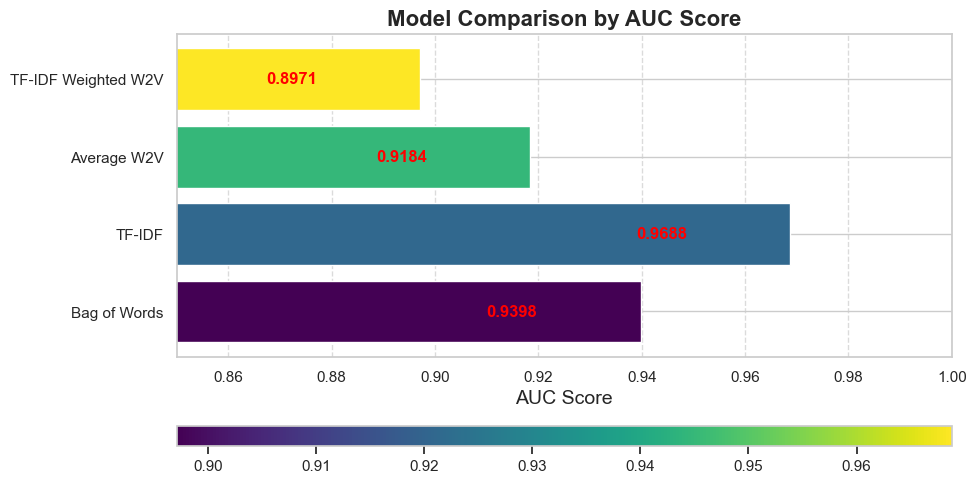

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
models = ['Bag of Words', 'TF-IDF', 'Average W2V', 'TF-IDF Weighted W2V']
auc_scores = [0.9398, 0.9688, 0.9184, 0.8971]

# Create a colormap based on the AUC scores
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# Create a bar chart with the new color scheme
plt.figure(figsize=(10, 6))
bars = plt.barh(models, auc_scores, color=colors)

# Add labels inside the bars for better readability
for index, value in enumerate(auc_scores):
    plt.text(value - 0.02, index, f'{value:.4f}', va='center', ha='right', fontsize=12, color='red', weight='bold')

plt.xlabel('AUC Score', fontsize=14)
plt.title('Model Comparison by AUC Score', fontsize=16, weight='bold')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust x-axis limits to prevent text from overlapping the border
plt.xlim(0.85, 1.0)

# Optional: Add color bar for reference, but adjust its position to avoid overlap
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(auc_scores), vmax=max(auc_scores)))
sm.set_array([])
plt.colorbar(sm, orientation='horizontal', pad=0.15, aspect=40)  # Moved color bar away from x-axis

plt.show()


In [72]:
review = "This product was excellent and exceeded my expectations."

example_review = "This product is bad! I dont love it."
sentiment, probability = analysis_review(review, model_tfidf, tfidf_vect)
print(f"Review: '{review}'")
print(f"Sentiment: {sentiment} (Probability: {probability:.4f})")

Review: 'This product is bad! I dont love it.'
Sentiment: Positive (Probability: 0.5050)
